## Pulse Rate Algorithm

We use the **Troika**[1] dataset to build the learning algorithm.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import etl
import ml
import plot_util
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')
print(f'sklearn version: {sklearn.__version__}')

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Numpy version: 1.19.1
Scipy version: 1.5.2
sklearn version: 0.23.2


# Algorithm implementation and evaluation

In [14]:
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = etl.LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return ml.AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl, train=False):
    """
    Infer the pulse rate of a time signal and compare it with the labels ref_fl
    Return per-estimate errors and confidence as a 2-tuple of numpy arrays.
    """
    ## hyperparameters:
    # sampling frequency:
    FS = 125
    # window sizes in seconds:
    WINDOW_LENGTH_SEC = 8
    WINDOW_SHIFT_SEC = 2
    # transform to data points:
    window_length = WINDOW_LENGTH_SEC * FS
    window_shift = WINDOW_SHIFT_SEC * FS
    BPM_MIN = 40
    BPM_MAX = 240
    # transform to Hz:
    min_freq = BPM_MIN / 60
    max_freq = BPM_MAX / 60
    # fft window length
    # use n>len(time_series) -> we pad the input signal with
    # zeros so that we get a higher resolution in frequency space
    n_fft = window_length * 4

    # number of trees in Random forest:
    n_estimators = 130
    max_tree_depth = 18
    # nmber of trees in Random forest:
    n_estimators_opt = [100, 130, 150, 300, 350]
    max_truee_depth_opt = [14, 16, 18]

    peaks_param = {
        'ppg': {
            'nr_peaks': 6,
            'height': 0.1,
            'distance': 5,
            'prominence': 0.2,
            'wlen': 200,
            'pad_value': -1,
        },
    #     'acc_abs': {
    #         'nr_peaks': 4,
    #         'height': 0.2,
    #         'distance': 10,
    #         'prominence': 0.2,
    #         'wlen': 100,
    #         'pad_value': -1,
    #     },
        'acc_sum': {
            'nr_peaks': 6,
            'height': 0.2,
            'distance': 10,
            'prominence': 0.2,
            'wlen': 100,
            'pad_value': -1,
        },
    }
    frac_en_param = {
    #     'ppg': {
    #         'num_intervals': 8,
    #     },
    # #     'acc_abs': {
    # #         'num_intervals': 4,
    # #     },
    #     'acc_sum': {
    #         'num_intervals': 8,
    #     },
    }
    ########################################################################################################
    ## setup and compute regressor model:
    # read data files:
    data_files_train, ref_files_train = etl.LoadTroikaDataset()
    # import raw input data:
    input_data_raw_train = etl.import_input_data(files=data_files_train)
    # import labels:
    labels_raw_train = etl.import_labels(files=ref_files_train)

    # get raw (window) data:
    dict_data_raw_window_train, labels_train, groups_train = etl.raw_data(
        input_data_raw=input_data_raw_train,
        labels_raw=labels_raw_train,
        window_length=window_length,
        window_shift=window_shift,
        freq_range=(min_freq, max_freq),
        fs=FS,
        n_fft=n_fft)


    # get all features:
    dict_features_train = etl.featurize(
        dict_raw_window_data=dict_data_raw_window_train,
        peaks_param=peaks_param,
        frac_en_param=frac_en_param,
        freq_range=(min_freq, max_freq)
    )
    features_train, feature_names_train = etl.transform_features(dict_features=dict_features_train)
    
    if train:
        df_best_hparams = ml.hyperparam_selection(
            features=features_train,
            labels=labels_train,
            groups=groups_train,
            n_estimators_opt=n_estimators_opt,
            max_tree_depth_opt=max_tree_depth_opt
        )
    else:
        df_best_hparams = None
    
    
    model = ml.train_best_rpr_algorithm(
        features=features_train,
        labels=labels_train,
        df_hparams=df_best_hparams,
        max_tree_depth=max_tree_depth,
        n_estimators=n_estimators
    )
    
    ########################################################################################################
    ## apply model to data:
    # Load data and labels:
    ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=data_fl)
    labels_raw = list(etl.import_labels(files=[ref_fl]).values())[0]
    
    # 
    infer_data, infer_dict_features = etl.prepare_inference_data(
        ppg=ppg,
        accx=accx,
        accy=accy,
        accz=accz,
        window_length=window_length,
        window_shift=window_shift,
        freq_range=(min_freq, max_freq),
        fs=FS,
        n_fft=n_fft,
        peaks_param=peaks_param,
        frac_en_param=frac_en_param
    )
    infer_features, infere_data_names = etl.transform_features(dict_features=infer_dict_features)
    # predict pulse rate estimates (in bpm):
    infer_pred = model.predict(infer_features)

    # per-estimate error:
    errors = infer_pred - labels_raw
    
    # confidence of each estimate:
    # we sum the frequency spectrum near the pulse rate estimate and dividing
    # it by the sum of the entire spectrum (defined by the min_freq and max_freq interval)..
    confidence_freq_range = 0.1 * (max_freq - min_freq)
    cfd = ml.confidence(
        freqs=infer_data['freqs'],
        fft=infer_data['fft_ppg'],
        y_pred=infer_pred,
        confidence_freq_range=confidence_freq_range,
        freq_range=(min_freq, max_freq)
    )

    return errors, cfd

In [15]:
# read data files:
data_files, ref_files = etl.LoadTroikaDataset()
errors, cfd = RunPulseRateAlgorithm(
    data_fl=data_files[0],
    ref_fl=ref_files[0],
    train=False
)
ml.AggregateErrorMetric(pr_errors=errors, confidence_est=cfd)

2.9094489914021544

In [16]:
Evaluate()

1.896822816611637

This evaluation of the total mean absolute error is not a realistic estimate of the performance of the algorithm because it is calculated on data which the ML model has been trained on

# ML training, hyperparameter selection and evaluation

In [5]:
# hyperparameters:
# sampling frequency:
FS = 125
# window sizes in seconds:
WINDOW_LENGTH_SEC = 8
WINDOW_SHIFT_SEC = 2
# transform to data points:
window_length = WINDOW_LENGTH_SEC * FS
window_shift = WINDOW_SHIFT_SEC * FS
BPM_MIN = 40
BPM_MAX = 240
# transform to Hz:
min_freq = BPM_MIN / 60
max_freq = BPM_MAX / 60
# fft window length
# use n>len(time_series) -> we pad the input signal with
# zeros so that we get a higher resolution in frequency space
n_fft = window_length * 4

# number of trees in Random forest:
n_estimators_opt = [100, 130, 150, 300, 350]
max_tree_depth_opt = [14, 16, 18]

peaks_param = {
    'ppg': {
        'nr_peaks': 6,
        'height': 0.1,
        'distance': 5,
        'prominence': 0.2,
        'wlen': 200,
        'pad_value': -1,
    },
#     'acc_abs': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': 0.2,
#         'wlen': 100,
#         'pad_value': -1,
#     },
    'acc_sum': {
        'nr_peaks': 6,
        'height': 0.2,
        'distance': 10,
        'prominence': 0.2,
        'wlen': 100,
        'pad_value': -1,
    },
}
frac_en_param = {
#     'ppg': {
#         'num_intervals': 8,
#     },
# #     'acc_abs': {
# #         'num_intervals': 4,
# #     },
#     'acc_sum': {
#         'num_intervals': 8,
#     },
}

Train model for each hyperparameter pair:

In [6]:
%%time
# read data files:
data_files, ref_files = etl.LoadTroikaDataset()
# # print information about imported files
# etl.data_information(
#     file_data=data_files,
#     file_label=ref_files,
#     fs=FS,
#     window_shift_sec=WINDOW_SHIFT_SEC,
#     window_length_sec=WINDOW_LENGTH_SEC
# )
# import raw input data:
input_data_raw = etl.import_input_data(files=data_files)
# import labels:
labels_raw = etl.import_labels(files=ref_files)

# get raw (window) data:
dict_data_raw_window, labels, groups = etl.raw_data(
    input_data_raw=input_data_raw,
    labels_raw=labels_raw,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft)

# get all features:
dict_features = etl.featurize(
    dict_raw_window_data=dict_data_raw_window,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param,
    freq_range=(min_freq, max_freq)
)
features, feature_names = etl.transform_features(dict_features=dict_features)

df_best_hparams = ml.hyperparam_selection(
    features=features,
    labels=labels,
    groups=groups,
    n_estimators_opt=n_estimators_opt,
    max_tree_depth_opt=max_tree_depth_opt
)

it. 1/12: MAE test set: 15.261177719829988
it. 2/12: MAE test set: 13.285771348280862
it. 3/12: MAE test set: 10.852959218816476
it. 4/12: MAE test set: 9.188941611883498
it. 5/12: MAE test set: 16.83393293120066
it. 6/12: MAE test set: 10.42268900574218
it. 7/12: MAE test set: 10.879801148184443
it. 8/12: MAE test set: 10.109897600813094
it. 9/12: MAE test set: 7.26308586710187
it. 10/12: MAE test set: 21.16976247580573
it. 11/12: MAE test set: 9.765918531123544
it. 12/12: MAE test set: 10.741510481927845
CPU times: user 1h 5min 32s, sys: 1min 7s, total: 1h 6min 39s
Wall time: 13min 57s


The following tabel represents for each test set the best pair of hyperparameters (max_tree_depth and n_estimators) and the validation and test set metrics:

In [7]:
df_best_hparams

,max_tree_depth,n_estimators,test_mae,test_mse,valid_mae,valid_mse,valid_score_mean,valid_score_std
0,18.0,130.0,15.261178,446.705265,12.589373,277.198564,0.324637,0.565116
1,18.0,130.0,13.285771,298.595574,12.589373,277.198564,0.324637,0.565116
2,16.0,130.0,10.852959,186.208702,12.524364,275.459572,0.268227,0.604226
3,18.0,300.0,9.188942,145.454017,12.618631,282.217552,0.225711,0.528870
4,18.0,130.0,16.833933,459.147935,12.433296,273.860065,0.179190,0.627702
5,18.0,130.0,10.422689,167.973000,12.433296,273.860065,0.179190,0.627702
6,18.0,130.0,10.879801,256.436815,12.774636,284.983290,0.183186,0.572707
7,16.0,130.0,10.109898,151.458743,12.542605,275.795507,0.128343,0.709046
8,18.0,150.0,7.263086,98.750932,13.214022,306.085711,0.202343,0.482128
9,16.0,130.0,21.169762,534.223735,12.694508,281.998831,0.180368,0.629589


Calculate the final model:

In [8]:
model = ml.train_best_rpr_algorithm(
    features=features,
    labels=labels,
    df_hparams=df_best_hparams,
    max_tree_depth=None,
    n_estimators=None
)
model

RandomForestRegressor(max_depth=18, n_estimators=130, n_jobs=8, random_state=42)

# ML model metric and performance visualization on the training dataset
We visualize the model performance on the training data set because we trained the final model on the complete available TROIKA dataset

Visualization in the frequency space of the worst predictions:

group: data_06_type02
label: 83.1486 BPM (1.38581 Hz)
absolute error: 27.05318103312149
group: data_01_type01
label: 88.23529411764706 BPM (1.4705882352941175 Hz)
absolute error: 21.345661222190998
group: data_06_type02
label: 93.75 BPM (1.5625 Hz)
absolute error: 20.837716303350675
group: data_01_type01
label: 84.65011286681715 BPM (1.4108352144469525 Hz)
absolute error: 20.203589800265846
group: data_01_type01
label: 163.89177939646203 BPM (2.7315296566077003 Hz)
absolute error: 19.601834651482534


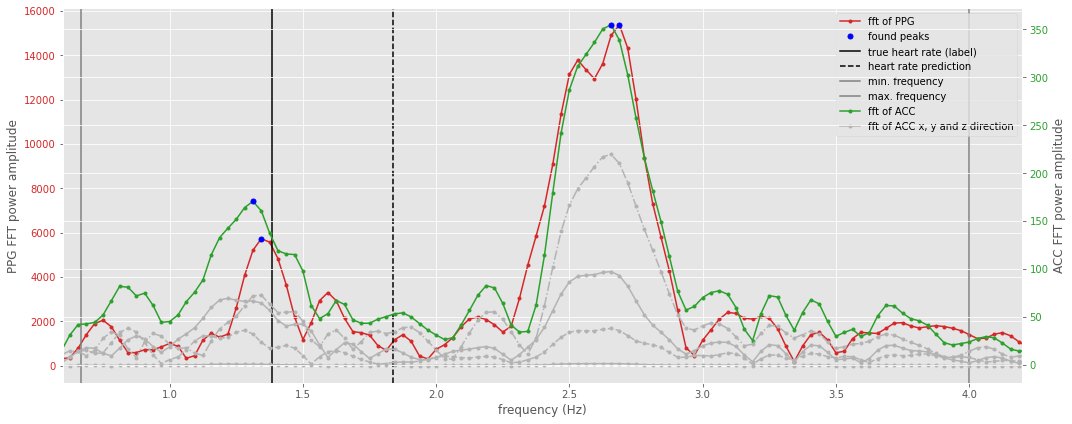

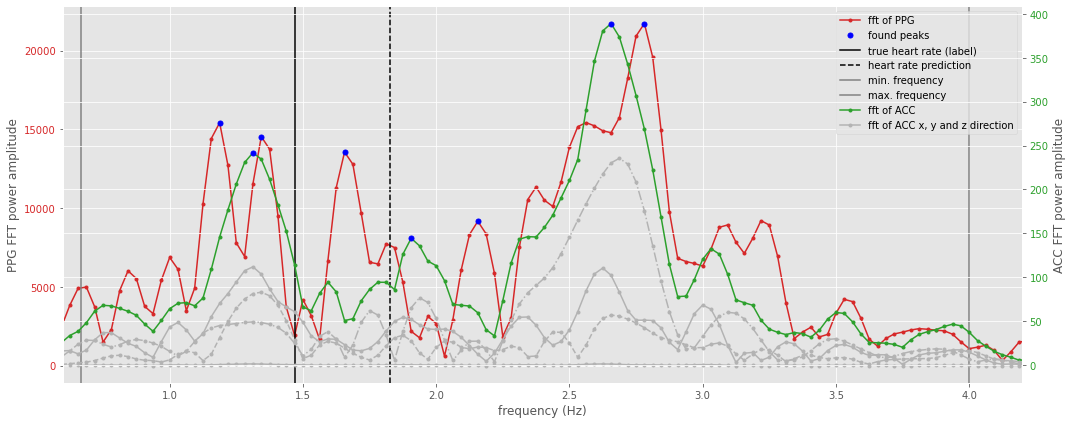

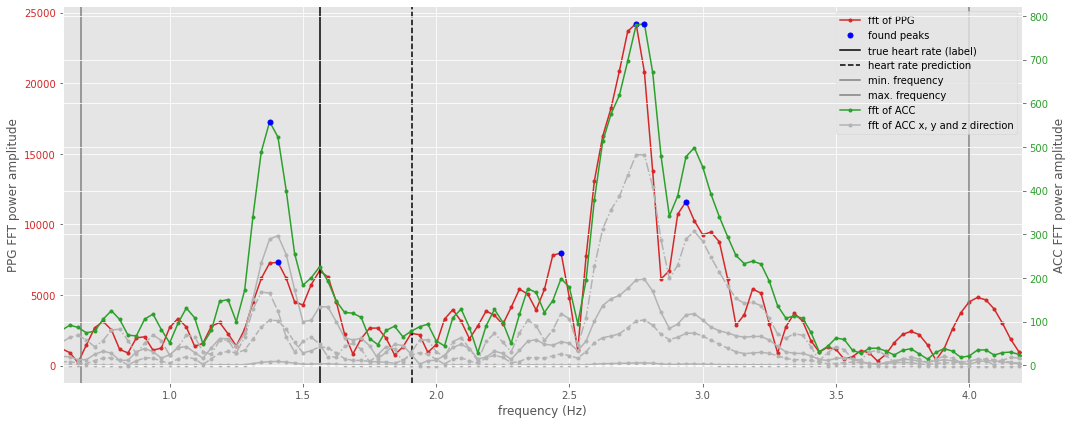

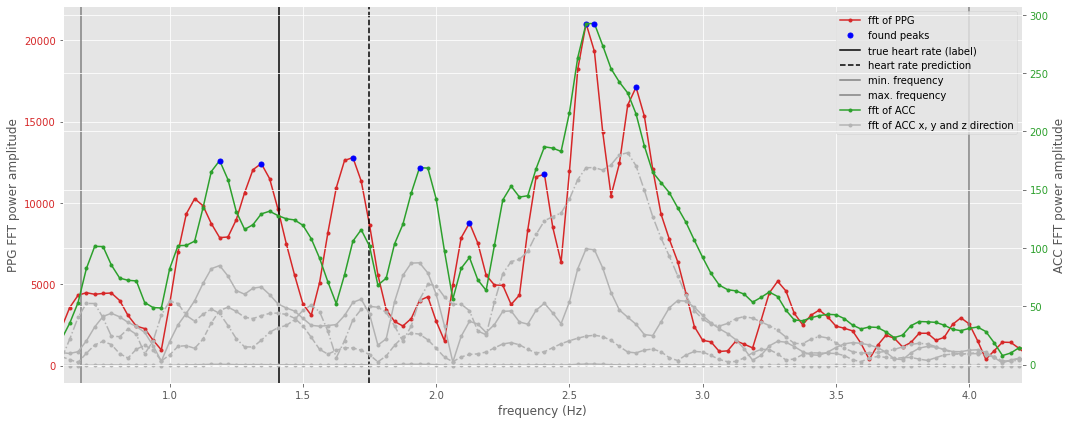

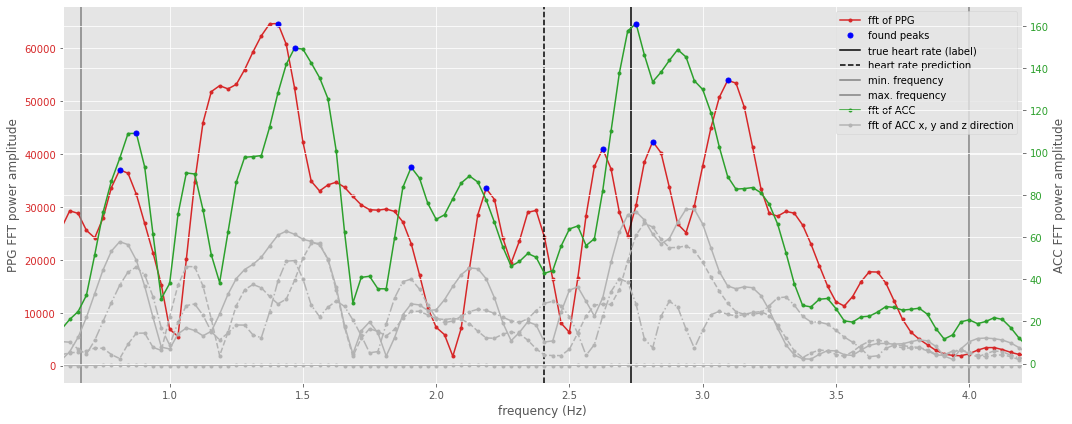

In [9]:
pred_all = model.predict(features)
abs_err_all = np.abs(labels - pred_all)
idx_mae_all_sorted = abs_err_all.argsort()[::-1]

# plot a window data point
for i in idx_mae_all_sorted[:5]:
    abr = 'sum'
    fig = plot_util.plot_window_prediction(
        freqs=dict_data_raw_window['freqs'][i],
        ppg_fft=dict_data_raw_window['fft_ppg'][i],
        ppg_peaks_freqs=dict_features['peaks_freq_ppg'][i],
        ppg_peaks_pwr=dict_features['peaks_pwr_ppg'][i],
        ppg_label=labels[i]/60,
        ppg_pred=pred_all[i]/60,
        acc_fft=dict_data_raw_window[f'fft_acc_{abr}'][i],
        accx_fft=dict_data_raw_window['fft_accx'][i],
        accy_fft=dict_data_raw_window['fft_accy'][i],
        accz_fft=dict_data_raw_window['fft_accz'][i],
        acc_peaks_freqs=dict_features[f'peaks_freq_acc_{abr}'][i],
        acc_peaks_pwr=dict_features[f'peaks_pwr_acc_{abr}'][i],
        min_freq=min_freq,
        max_freq=max_freq
    )
    print(f'group: {groups[i]}')
    print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')
    print(f'absolute error: {abs_err_all[i]}')


Importance of each feature:

In [19]:
sorted(list(zip(model.feature_importances_, feature_names)), reverse=True)

[(0.2868910130600635, 'peaks_pwr_acc_sum_1'),
 (0.2567104022972771, 'peaks_pwr_ppg_0'),
 (0.19332309933518033, 'peaks_freq_ppg_0'),
 (0.06074896279263204, 'peaks_freq_acc_sum_0'),
 (0.05312592824180621, 'peaks_pwr_acc_sum_0'),
 (0.03320862407846173, 'peaks_freq_ppg_1'),
 (0.02541273081554391, 'peaks_pwr_ppg_1'),
 (0.024666172037629445, 'peaks_freq_ppg_2'),
 (0.012792785504297858, 'peaks_freq_acc_sum_1'),
 (0.00954123892955855, 'peaks_pwr_ppg_2'),
 (0.009355408920239408, 'peaks_freq_ppg_4'),
 (0.005672489877228309, 'peaks_pwr_ppg_3'),
 (0.0056320546609475155, 'peaks_freq_ppg_3'),
 (0.005488329944703388, 'peaks_pwr_acc_sum_2'),
 (0.005239100839702362, 'peaks_freq_acc_sum_2'),
 (0.003532659163797955, 'peaks_pwr_ppg_4'),
 (0.002753242630559503, 'peaks_pwr_ppg_5'),
 (0.0025637868704295017, 'peaks_pwr_acc_sum_3'),
 (0.0020102031209303837, 'peaks_freq_ppg_5'),
 (0.0007459285118108725, 'peaks_freq_acc_sum_3'),
 (0.00030735937839814056, 'peaks_freq_acc_sum_4'),
 (0.00017420005115158007, 'peaks_

# inference

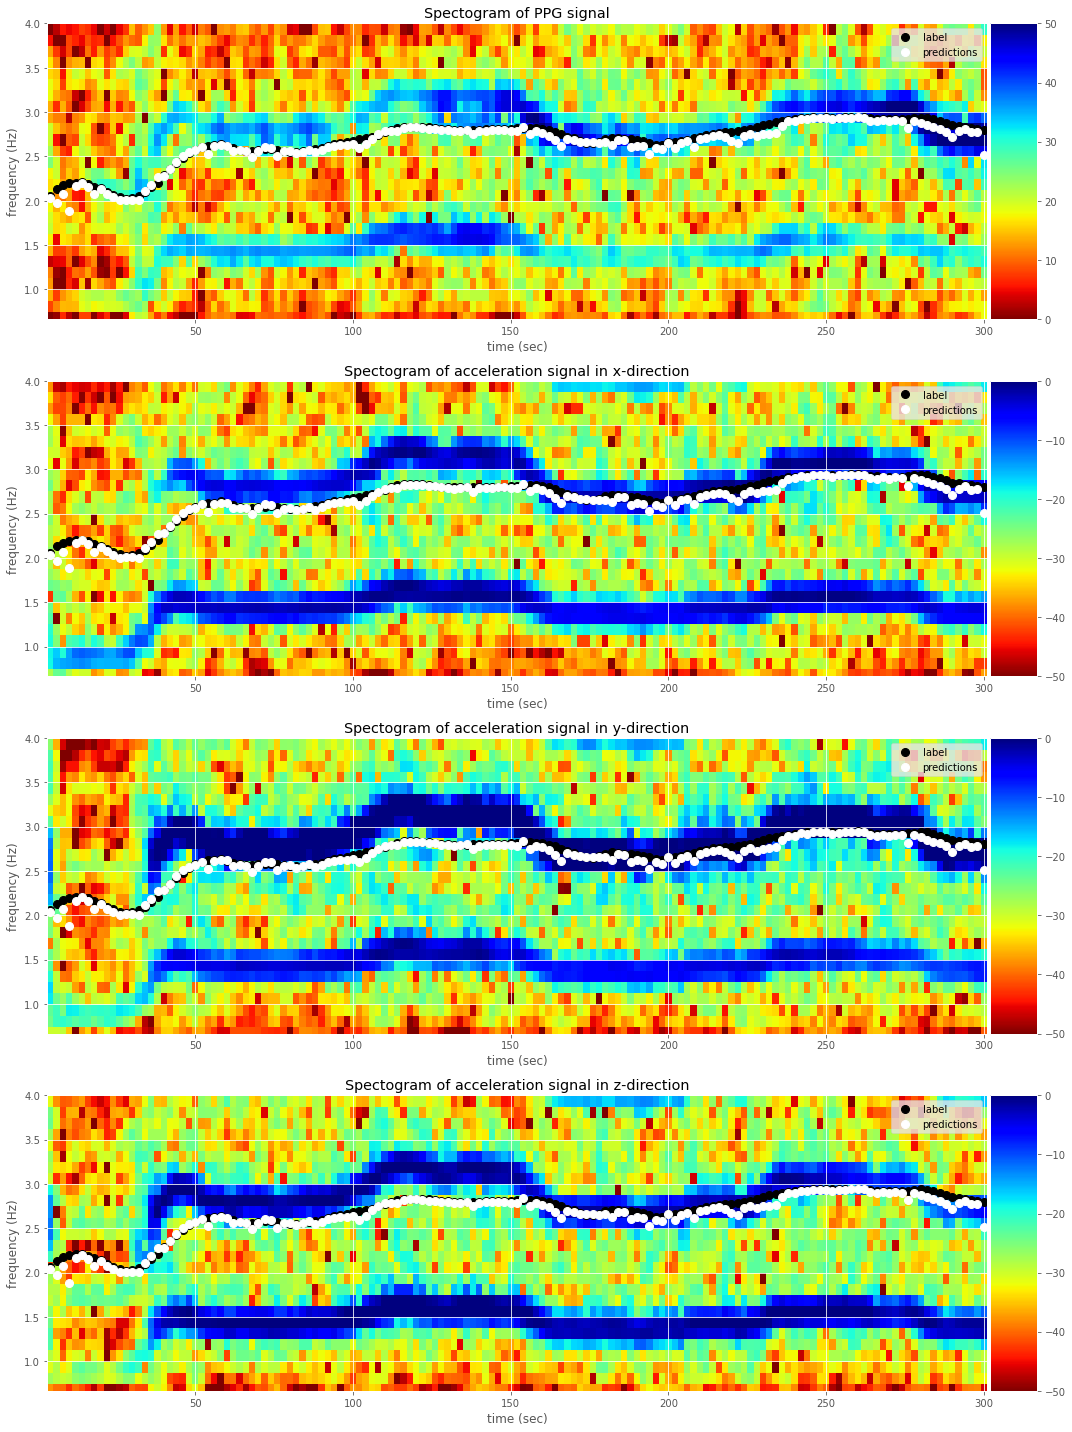

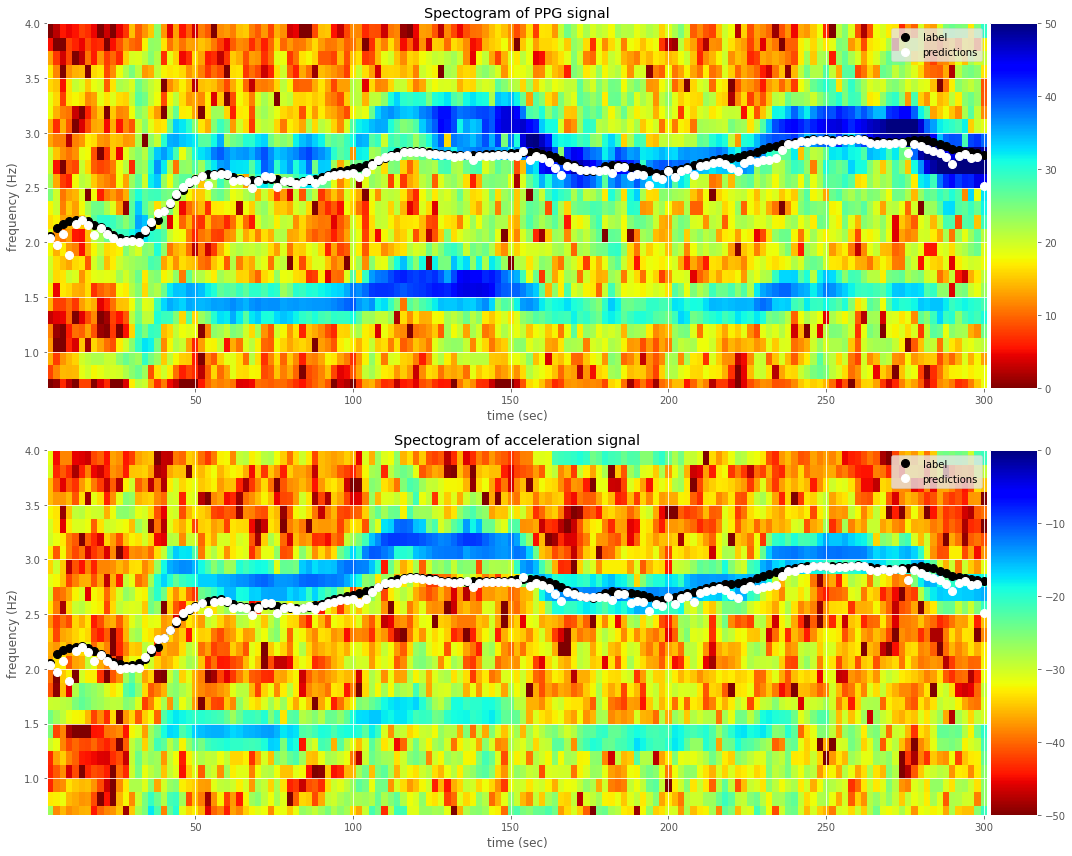

In [11]:
file = data_files[9]

ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=file)
file_key = file.split('/')[-1].split('.')[0].lower()
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accz'], pass_band=(min_freq, max_freq), fs=FS)
acc_abs, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
lbls = labels_raw[f'ref{file_key[4:]}']/60

infer_data, infer_dict_features = etl.prepare_inference_data(
    ppg=ppg,
    accx=accx,
    accy=accy,
    accz=accz,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param
)
infer_features, infere_data_names = etl.transform_features(dict_features=infer_dict_features)
# predict pulse rate estimates (in bpm):
pred = model.predict(infer_features)

fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

# Real test set evaluations

In [20]:
def load_test_data():
    """
    Get filenames in considered data directory.
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data (labels)
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/test_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def Evaluate_test_data():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = load_test_data()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return ml.AggregateErrorMetric(errs, confs)



data_files_test, ref_files_test = load_test_data()

errors, cfd = RunPulseRateAlgorithm(data_fl=data_files_test[0], ref_fl=ref_files_test[0])
ml.AggregateErrorMetric(pr_errors=errors, confidence_est=cfd)

9.142876917223084

In [21]:
Evaluate_test_data()

9.142876917223088

In [22]:
test_abs_err = np.abs(errors)

In [23]:
ppg_test, accx_test, accy_test, accz_test = etl.LoadTroikaDataFile(data_fl=data_files_test[0])
labels_raw_test = etl.import_labels(files=ref_files_test)['ref_09_type02']

ppg_raw_filtered_test = etl.bandpass_filter(signal=ppg_test, pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered_test = etl.bandpass_filter(signal=accx_test, pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered_test = etl.bandpass_filter(signal=accy_test, pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered_test = etl.bandpass_filter(signal=accz_test, pass_band=(min_freq, max_freq), fs=FS)
acc_abs_test, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
lbls_test = labels_raw_test / 60

infer_data_test, infer_dict_features_test = etl.prepare_inference_data(
    ppg=ppg_test,
    accx=accx_test,
    accy=accy_test,
    accz=accz_test,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param
)
infer_features_test, infere_data_names_test = etl.transform_features(dict_features=infer_dict_features_test)
# predict pulse rate estimates (in bpm):
pred_test = model.predict(infer_features_test)

group: data_01_type01
label: 79.59905660377359 BPM (1.3266509433962266 Hz)
absolute error: 0.3635663590182361


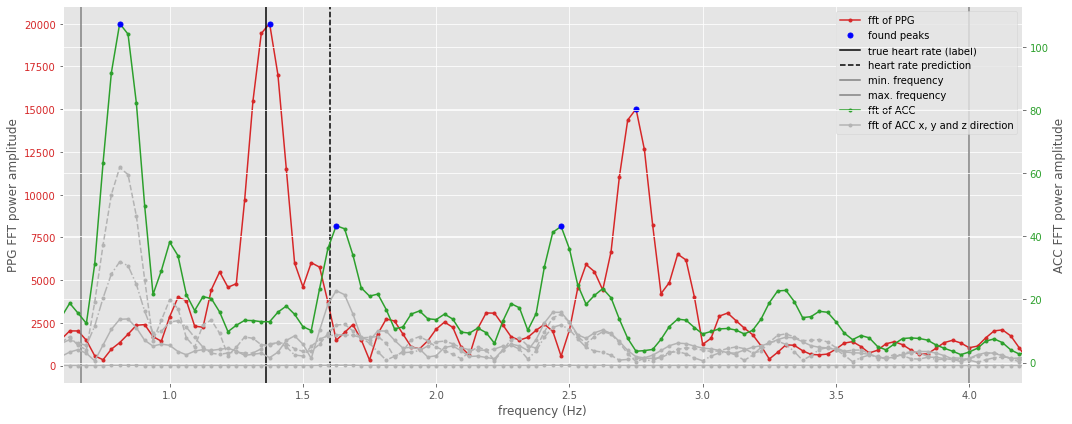

In [24]:
# plot a window data point
# for i in idx_mae_all_sorted[-10:]:
i = 10
abr = 'sum'
fig = plot_util.plot_window_prediction(
    freqs=infer_data_test['freqs'][i],
    ppg_fft=infer_data_test['fft_ppg'][i],
    ppg_peaks_freqs=infer_dict_features_test['peaks_freq_ppg'][i],
    ppg_peaks_pwr=infer_dict_features_test['peaks_pwr_ppg'][i],
    ppg_label=lbls_test[i],
    ppg_pred=pred_test[i]/60,
    acc_fft=infer_data[f'fft_acc_{abr}'][i],
    accx_fft=infer_data['fft_accx'][i],
    accy_fft=infer_data['fft_accy'][i],
    accz_fft=infer_data['fft_accz'][i],
    acc_peaks_freqs=infer_dict_features[f'peaks_freq_acc_{abr}'][i],
    acc_peaks_pwr=infer_dict_features[f'peaks_pwr_acc_{abr}'][i],
    min_freq=min_freq,
    max_freq=max_freq
)
print(f'group: {groups[i]}')
print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')
print(f'absolute error: {abs_err_all[i]}')


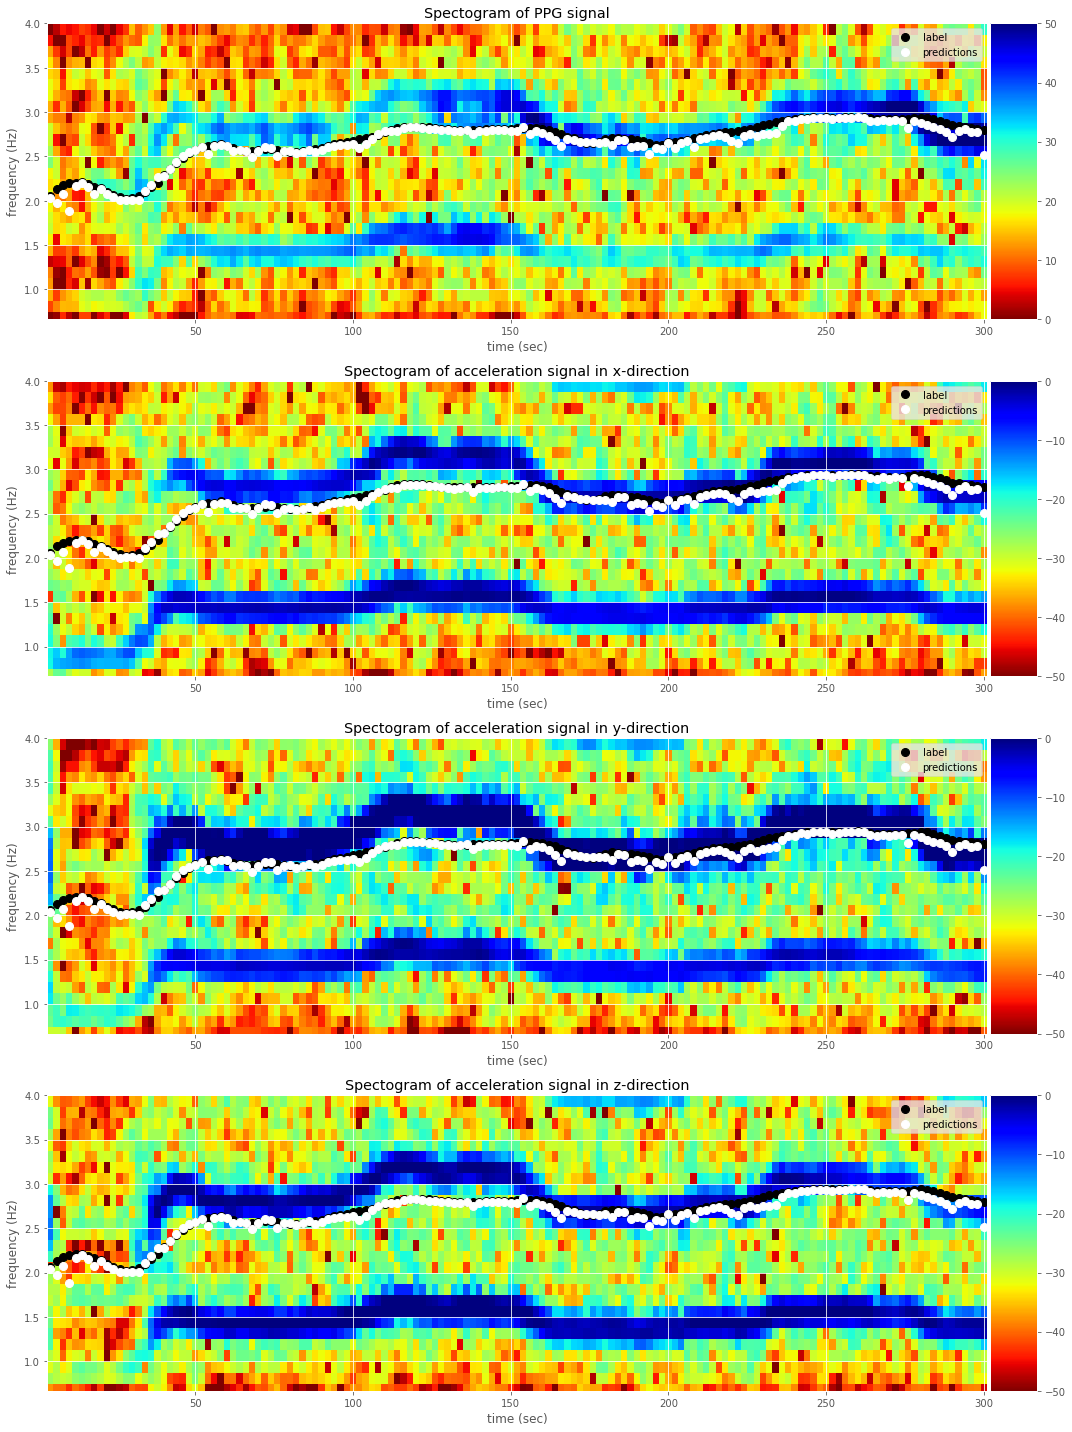

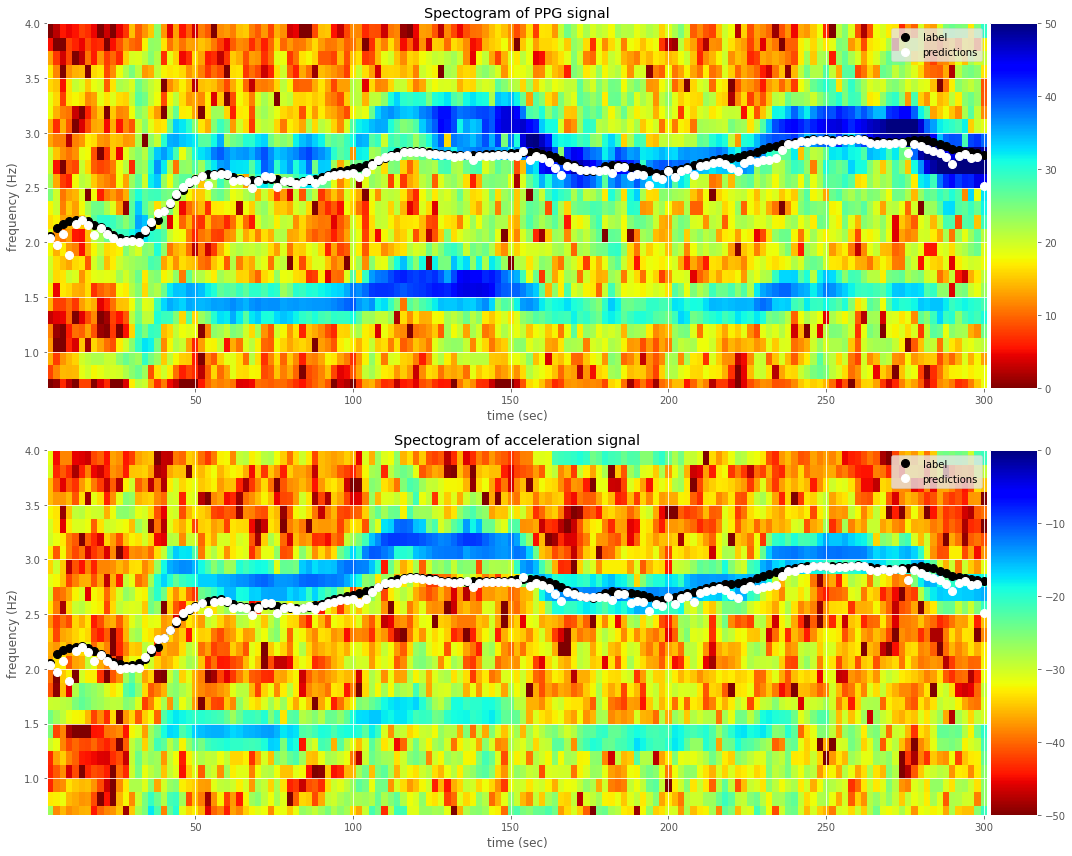

In [25]:
fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

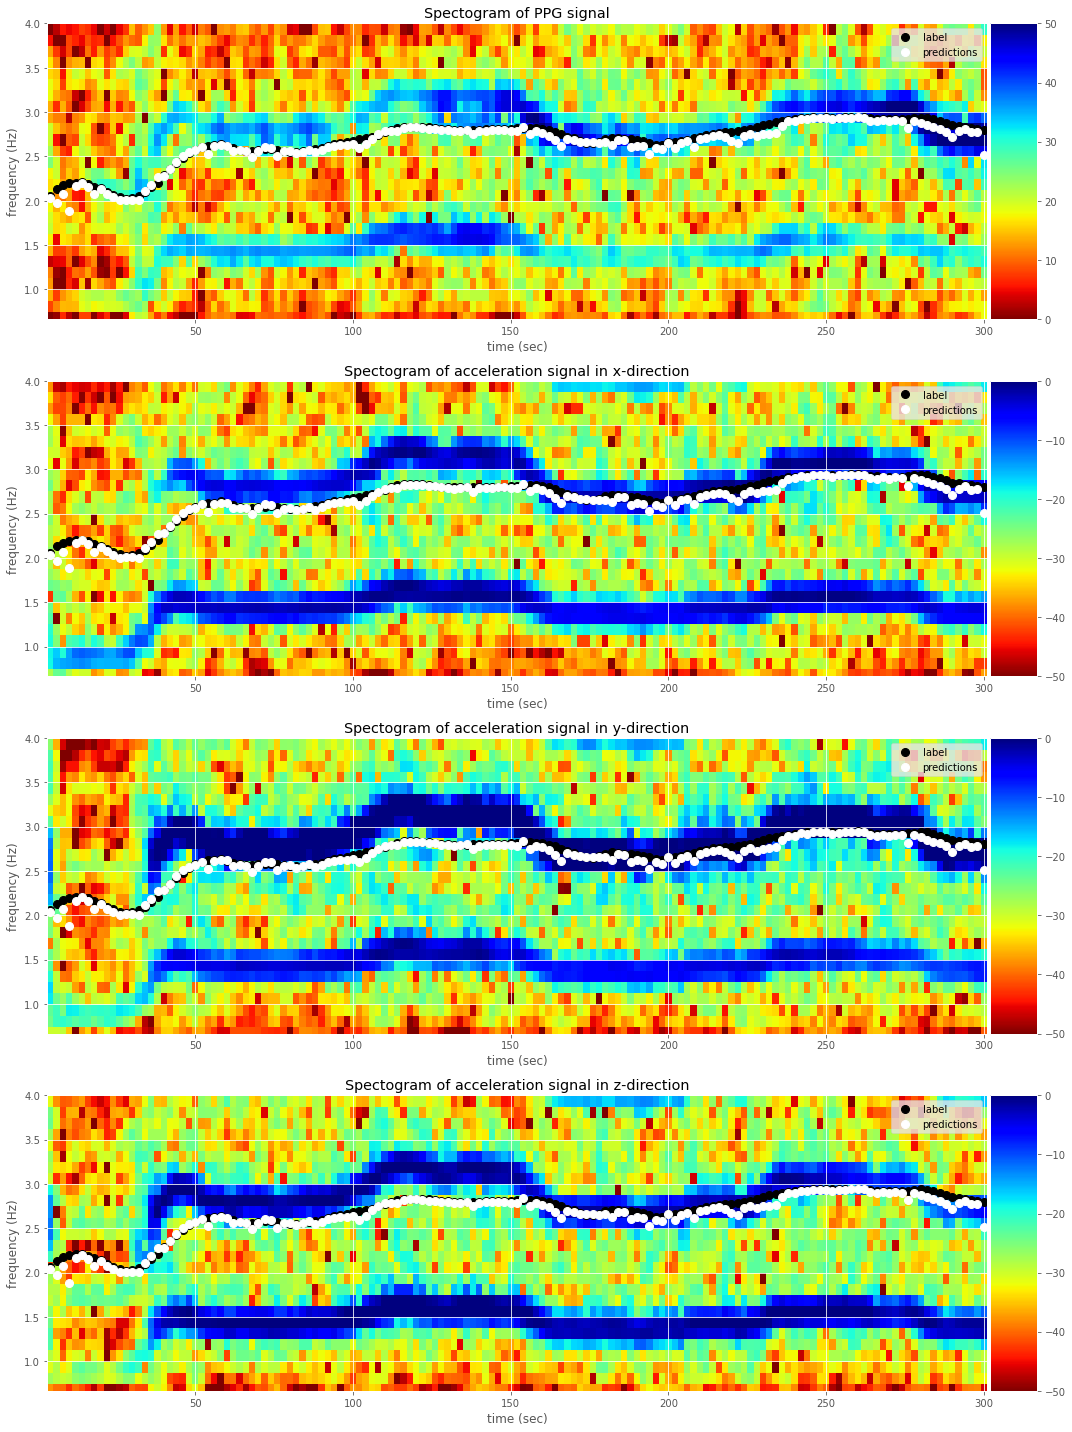

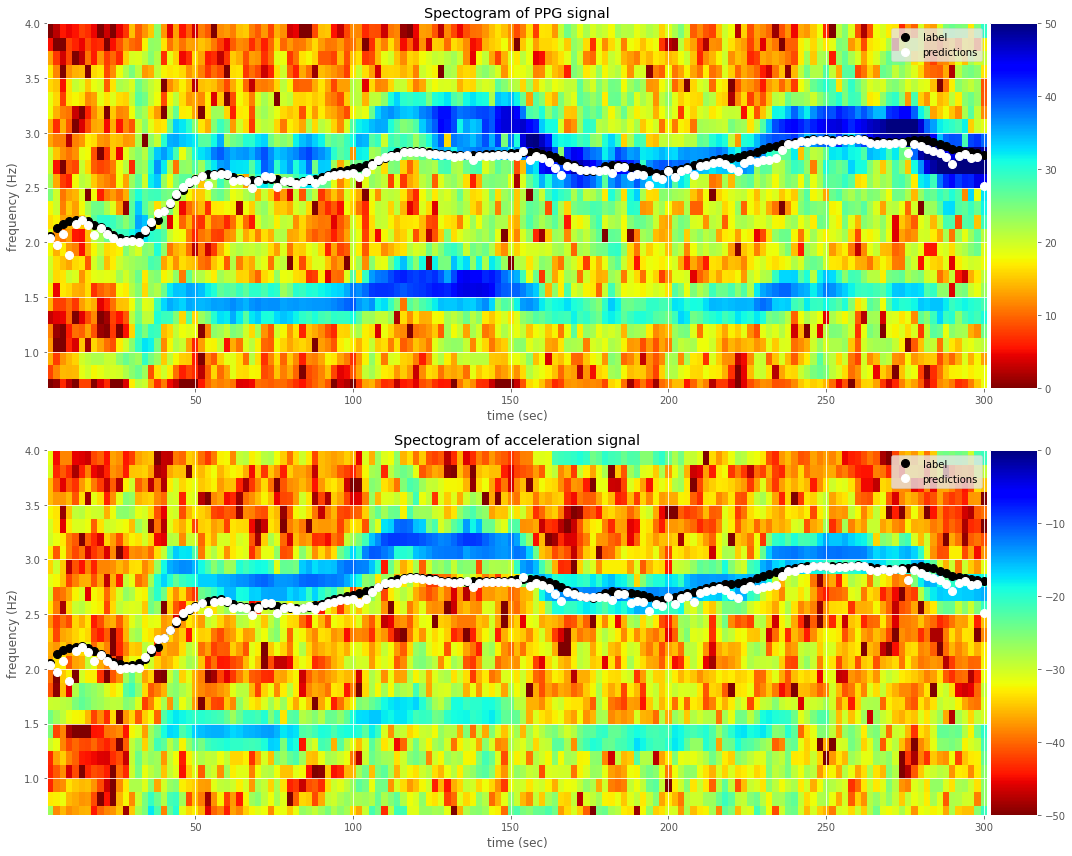

In [25]:
fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

1. Code Description: 
    For all computations the data have to be located at relative path data/troika/training_data/.
    This Python code computes a Random Forest Regressor model which is trained on the TROIKA dataset (see section data description) and predicts the heart rate (in BPM) for an input signal consisting of a PPG signal and x-, y- and z-axis accelerometer signals. There are 2 Ways of code execution:
    - Run function RunPulseRateAlgorithm(data_fl, ref_fl, train=False) to analyze the algorithm performance on the TROIKA dataset. The arguments are:
        - data_fl: path name to a .mat file from the TROIKA dataset (or similar data structure) with PPG and x-, y-, z-axis accelerometer signals.
        - ref_fl: path name to a .mat file containing ground truth heart rate data from the TROIKA dataset (or similar data structure)
        - train: a boolean flag that determines if the Random Forest Algorithm should be trained on the complete training TROIKA dataset using nested cross-validation hyperparameter optimization. If False (default) the model is trained on the complete TROIKA dataset with pre-defined hyperparameters (n_estimators=, max_depth=).
        
    RunPulseRateAlgorithm() computes the heart rate and compares it with the labels which are given in the reference files ref_fl. It outputs the errors (difference) between estimates and labels and the confidence for each prediction. 
    The Evaluate() function computes the overall mean absolute error at 90% availability on the TROIKA dataset.
    - Predict heart rate. A minimal code sample looks like this:
<code>
    data_files, ref_files = etl.LoadTroikaDataset()
    # import raw input data:
    input_data_raw = etl.import_input_data(files=data_files)
    # import labels:
    labels_raw = etl.import_labels(files=ref_files)
    # get raw (window) data:
    dict_data_raw_window, labels, groups = etl.raw_data(
        input_data_raw=input_data_raw,
        labels_raw=labels_raw,
        window_length=window_length,
        window_shift=window_shift,
        freq_range=(min_freq, max_freq),
        fs=FS,
        n_fft=n_fft)
    # get all features:
    dict_features = etl.featurize(
        dict_raw_window_data=dict_data_raw_window,
        peaks_param=peaks_param,
        frac_en_param=frac_en_param,
        freq_range=(min_freq, max_freq)
    )
    features, feature_names = etl.transform_features(dict_features=dict_features)
    df_best_hparams = ml.hyperparam_selection(
        features=features,
        labels=labels,
        groups=groups,
        n_estimators_opt=n_estimators_opt,
        max_tree_depth_opt=max_tree_depth_opt
    )
    model = ml.train_best_rpr_algorithm(
        features=features,
        labels=labels,
        df_hparams=df_best_hparams,
        max_tree_depth=None,
        n_estimators=None
    )
    pred_all = model.predict(features)
</code>
    First the file paths are loaded (LoadTroikaDataset()), then the input data (import_input_data()) and the ground truth heart rates (import_labels()) are imported. After that the data is prepared (raw_data()), featurized (featurize()) and transformed into the appropriate form (transform_features()) before the machine learning model - a Random Forest Regressor - is used with a nested cross-validation (hyperparam_selection()). The best hyperparameter pair (based on the test set of each LeaveOneOutGroup) is used to train the final model (train_best_rpr_algorithm()). Predictions of heart rates can be made with the model.predict() command.
2. Data Description:
    For training, validating and testing the algorithm we use the TROIKA dataset. It contains two-channel PPG signals (recorded from wrist by two pulse oximeters), three-axis acceleration signals (recorded from wrist by accelerometer) and one-channel ECG signals (recorded from chest using wet ECG sonsors), all simultaneously recorded from subjects between 18 and 35 years.
    Data was collected during a period of around 5 minutes. Each subject was running on a treadmill with changing speeds.
    The ground truth heart rate data is computed from the ECG signals.
    
    To build a more complete dataset, these points can be taken into account:
    - more subjects/datapoints.
    - More information on each subject, e.g. age, heart condition, illnesses, gender and so on.
    - more extended age range
    - to get more accurate results it would be beneficial to record PPG and accelerometer signals on more points on the body.
    - include more exercises: running outside, cycling, swimming, team sports, ...

3. Algorithm Description:
    The algrorithm for predicting the heart rate takes advantage of the physiology of blood flow through ventricles. The origin of the blood flow in a human being is its heart. The heart contraction and expansion is summarized in the heart rate. This heart rate can be measured among others on the wrist of a human being. When the ventricles contract blood streams into the body. A PPG sensor on the wrist sends and receives LED light which is absorbed by the blood. At contraction there is more blood in the wrist. This leads to a lower signal in the PPG sensor because of the higher absorption rate. When the ventricles relax and expand blood is flowing back to the heart and less red blood celles are available in the wrist. This leads to a higher reflection rate and therefore a higher PPG signal. The movement of the arm can influence the PPG signal.
    
    The general idea of the algorithm is to predict the heart rate given a PPG signal and three channels of accelerometer signals. Tracking the accelerometer signals is necessary to account for arm movement
    
    In detail the algorithm works like this:
    
    1. ETL process:
        1. As inputs we use time series data of PPG signal, x-, y- and z-axis accelerometer signal.
        2. each time series data is split into windows of size 8 seconds. This is necessary because the ground truth
           heart rates are given in windows of 8 seconds.
        3. each windowed data is bandpass-filtered for frequencies in the range of 40-240 BPM. This range is useful because heart rates of healthy hearts are expected to be within this interval.
        4. We compute the real FFT signal for all window-sized data points.
        5. We summarize the three accelerometer channels by summing the FFT signals of the three channels. This gives the summed FFT accelerometer signal.
        6. For each window-sized data point we now can compute the features which are fed into the machine learning model:
            1. In the FFT PPG signals and the summed FFT accelerometer signals we look for frequency peaks and sort them by their power value. We save the frequencies of these peaks and their FFT power value. To find the peaks we use a function from the scipy module: sp.signal.find_peaks(). During algorithm training we try different values for the arguments (height, distance, prominence, threshold, wlen) of this function to find the best heart rate predictions.
            2. As additional features we also implemented a function that computes the fractional energy of smaller intervals of the frequency spectrum between 40 and 240 BPM. However, we found that if we ommit this feature we get estimates that are good enough. The fractional energy is used to compute the confidence of a heart rate prediction.
        7. We bring all features into the correct shape (a numpy array with rows ^= number of data points and columns ^= number of features).
    2. We train a Random Forest Regressor: Since we have a relatively small dataset we perform nested cross-validation. In each fold we train on 10 subjects and we leave 1 subject out for validation and 1 for testing. We train the regression model with different hyperparameters: n_estimators - number of trees in the random forest regressor model - and max_depth - maximum depth of each tree in the random forest. We optimize the mean absolut error between our predictions of the heart rate (in BPM) and the true heart rate. To get a more realistic measurement of the performance of each model we use the MAE estimate on the test dataset. This is done in the function hyperparam_selection(). Its output is a pandas DataFrame containing the best hyper-parameter selection and its validation and test set metrics for each run.
    3. To prepare the algorithm for the unknown test set, we chose by majority vote the best hyper-parameters and train the model one more time on the complete given TROIKA dataset. This is our final model which is tested against the unknown test data
    

4. Algorithm Performance:
    The algorithm performance was compared to the reference data from the TROIKA dataset. This reference data was computed from the ECG signal. It is used as ground truth/label for evaluating the algorithm performance. The ECG signal, measured at the chest is a much more robust measurement of the heart rate, especially if the subject and its wrist is in motion.
    
    The confidence of each estimation is equivalent to the fractional energy around the predicted heart rate frequency (summed FFT power signal divided by summed total FFT power signal of the PPG senser). These confidence estimates are used only to determine the 10% of the worst predictions. These 10% are discarded when the remaining predictions are evaluated against the ground truth.
    The resulting performance mean absolut error for the dataset at 90% availability is 1.9 BPM. 
    However this result is not realistic because the Random Forest Regressor has been fitted to the complete Troika dataset. For more useful metrics we can take a look at cross-validation metrics for each test set separately. These results are summarized in the following table:

In [27]:
df_best_hparams

,max_tree_depth,n_estimators,test_mae,test_mse,valid_mae,valid_mse,valid_score_mean,valid_score_std
0,18.0,130.0,15.261178,446.705265,12.589373,277.198564,0.324637,0.565116
1,18.0,130.0,13.285771,298.595574,12.589373,277.198564,0.324637,0.565116
2,16.0,130.0,10.852959,186.208702,12.524364,275.459572,0.268227,0.604226
3,18.0,300.0,9.188942,145.454017,12.618631,282.217552,0.225711,0.528870
4,18.0,130.0,16.833933,459.147935,12.433296,273.860065,0.179190,0.627702
5,18.0,130.0,10.422689,167.973000,12.433296,273.860065,0.179190,0.627702
6,18.0,130.0,10.879801,256.436815,12.774636,284.983290,0.183186,0.572707
7,16.0,130.0,10.109898,151.458743,12.542605,275.795507,0.128343,0.709046
8,18.0,150.0,7.263086,98.750932,13.214022,306.085711,0.202343,0.482128
9,16.0,130.0,21.169762,534.223735,12.694508,281.998831,0.180368,0.629589


    We see a more realistic mean absolut error ranging from 7.2 to 21.2 BPM.

    If we want to generalize the metric and confidence estimates e.g. to other datasets, we have take into account the characteristics of the TROIKA dataset.
    Data in the TROIKA dataset was recorded on a treatmill. These laboratory-like conditions might not be given in all datasets. Running outdoors might come with different arm movements. This would influence the accelerometer signals and affect the metric and confidence estimates. Furthermore, different activities will result in different arm movements which will not be accounted for in machine learning models based on the TROIKA dataset.
    
    The three most important features of the ML model are
        - the second most prominent peak in the FFT power signal of the (total) accelerometer signal (peaks_pwr_acc_sum_1)
        - the most prominent peak in the FFT power signal of the PPG signal (peaks_pwr_ppg_0)
        - the frequency of the most prominent peak in the FFT power signal of the PPG signal (peaks_freq_ppg_0)
    
    There are cases where the algorithm fails. A hard challenge for the algorithm is when the ground truth heart rate overlaps with the most prominent accelerometer signal or when no peak is detected near the ground truth (see images above).